In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
dftouse = pd.read_csv('newdf.csv')
dftouse.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffinhib,diffkda,diffrange,diffspree,difftank,diffturr,fbaron,fblood,fdrag,finhib,fturret,win
0,1,819,155,17067,3,17703,2,18.144444,-1,5,0,8,True,False,True,True,False,True
1,1,-685,24,-23447,0,-11396,-2,-20.117208,1,-7,1,-4,True,False,True,False,False,False
2,-1,658,16,-5988,0,-11734,-2,-21.416667,1,-3,1,-6,False,True,True,False,True,False
3,-1,-339,-127,-9102,-2,-17661,-2,-17.531349,1,-6,0,-7,False,False,False,False,False,False
4,0,756,162,12505,0,11899,1,26.059524,0,3,3,5,False,False,False,True,True,True


In [3]:
###Random forest classifier
#First we want to create mask values so we can split the dataframe into training and testing sets. 
#To do that we import 'train_test_split', and create mask values.
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.75)

In [4]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [5]:
#seeing if it worked out correctly
mask.shape, mask.sum()

((20223L,), 15167)

In [6]:
#Standardizeable variables
stdz = list(dftouse.columns)
stdz.remove('win')
stdz.remove('fblood') 
stdz.remove('finhib')
stdz.remove('fdrag')
stdz.remove('fbaron')
stdz.remove('fturret')
print(stdz)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffinhib', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'diffturr']


In [7]:
#adding mask column
dftouse['Mask'] = mask
#trainset to fit and standardize
trainset = dftouse.query('Mask == True')
testset = dftouse.query('Mask == False')
#test set train set
trainset = trainset[stdz]
testset = testset[stdz]

In [8]:
#standardizing our data
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
preprocessing.StandardScaler().fit(trainset)
fitdf = preprocessing.StandardScaler().fit_transform(dftouse[stdz])
newdf = pd.DataFrame(fitdf)
newdf.columns = trainset.columns

In [9]:
#replace values
dftouse[stdz] = newdf
dftouse.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffinhib,diffkda,diffrange,diffspree,difftank,diffturr,fbaron,fblood,fdrag,finhib,fturret,win,Mask
0,1.012372,0.427762,1.615697,0.818152,1.487001,1.482770,1.120933,0.744954,-0.848866,1.306314,-0.005191,1.454967,True,False,True,True,False,True,True
1,1.012372,-0.346850,0.360326,-1.028140,0.112277,-0.836434,-1.082311,-0.728606,0.857049,-1.736486,0.957995,-0.678958,True,False,True,False,False,False,True
2,-0.875690,0.344841,0.283662,-0.232503,0.112277,-0.863373,-1.082311,-0.778652,0.857049,-0.722219,0.957995,-1.034612,False,True,True,False,True,False,False
3,-0.875690,-0.168648,-1.086705,-0.374414,-0.804205,-1.335757,-1.082311,-0.629018,0.857049,-1.482920,-0.005191,-1.212439,False,False,False,False,False,False,True
4,0.068341,0.395315,1.682778,0.610254,0.112277,1.020188,0.570122,1.049785,0.004091,0.799181,2.884368,0.921486,False,False,False,True,True,True,True


In [10]:
#Now we will be using a Random Forest classifier to figure out which features are more 
#important in determining the probability of a team winning. First, we split the data set.

#columns with values to fit as the X values
lcols = list(dftouse.columns.values)
#removing the mask column from the list
lcols.remove('Mask')
#removing the win (y) response variables from the list
lcols.remove('win')
print(lcols)

['diffbaron', 'diffcc', 'diffcs', 'diffdmg', 'diffdrag', 'diffgold', 'diffinhib', 'diffkda', 'diffrange', 'diffspree', 'difftank', 'diffturr', 'fbaron', 'fblood', 'fdrag', 'finhib', 'fturret']


In [11]:
Xmatrix = dftouse[lcols].values
yvals = dftouse['win'].values

In [12]:
##split to train and test
X_train = Xmatrix[mask]
X_test = Xmatrix[~mask]
y_train = yvals[mask]
y_test = yvals[~mask]

In [13]:
#Now we'll get on with our Random Forest.
from sklearn.ensemble import RandomForestClassifier

In [14]:
##Create a large forest so we can better identify features
clfForest = RandomForestClassifier(n_jobs = 3, n_estimators = 100)

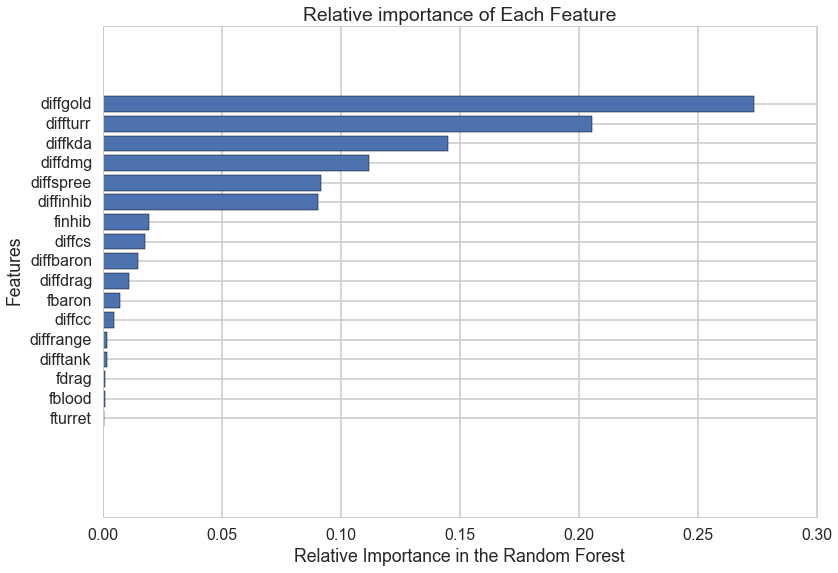

In [15]:
#We can graph importances.
#First we fit
clfForest = clfForest.fit(X_train, y_train)
#We can plot the importances
importances = clfForest.feature_importances_
importances, lcols = zip(*sorted(zip(importances, lcols)))
#plot importances
plt.barh(range(len(lcols)),importances,align='center')
plt.yticks(range(len(lcols)),lcols)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [16]:
#We can also see how this model did on the training and test set.
training_accuracy = clfForest.score(X_train, y_train)
test_accuracy = clfForest.score(X_test, y_test)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.99


In [23]:
dftouse.head()

,diffbaron,diffcc,diffcs,diffdmg,diffdrag,diffgold,diffinhib,diffkda,diffrange,diffspree,difftank,diffturr,fbaron,fblood,fdrag,finhib,fturret,win,Mask
0,1.012372,0.427762,1.615697,0.818152,1.487001,1.482770,1.120933,0.744954,-0.848866,1.306314,-0.005191,1.454967,True,False,True,True,False,True,True
1,1.012372,-0.346850,0.360326,-1.028140,0.112277,-0.836434,-1.082311,-0.728606,0.857049,-1.736486,0.957995,-0.678958,True,False,True,False,False,False,True
2,-0.875690,0.344841,0.283662,-0.232503,0.112277,-0.863373,-1.082311,-0.778652,0.857049,-0.722219,0.957995,-1.034612,False,True,True,False,True,False,False
3,-0.875690,-0.168648,-1.086705,-0.374414,-0.804205,-1.335757,-1.082311,-0.629018,0.857049,-1.482920,-0.005191,-1.212439,False,False,False,False,False,False,True
4,0.068341,0.395315,1.682778,0.610254,0.112277,1.020188,0.570122,1.049785,0.004091,0.799181,2.884368,0.921486,False,False,False,True,True,True,True


In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [27]:
formula = 'win ~ diffbaron + diffcc + diffcs + diffdmg + diffdrag + diffgold + diffinhib + diffkda + diffrange + diffspree + difftank + diffturr + fbaron + fblood + fdrag + finhib + fturret'
ols_model = smf.ols(formula, dftouse).fit()
ols_model.summary()

ValueError: For numerical factors, num_columns must be an int